In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
import pandas as pd

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import np_utils
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os
import shutil
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
tf.get_logger().setLevel('ERROR')

In [3]:
os.chdir('/content/drive/My Drive/Zevi')
os.listdir()

['Zevi_search_dataset.json',
 'd2vModel.d2v',
 'new_data.csv',
 'dict_file',
 'lsi_model',
 'tfidf_model',
 'lsi_model.projection',
 'tfidf_model_mm.index',
 'tfidf_model_mm',
 'lsi_model_mm',
 'lsi_model_mm.index',
 'matrix_index',
 'Zevi model.ipynb',
 'Final Model.ipynb',
 'Classifier Model.ipynb',
 'new_data1.json',
 'model.png']

In [4]:
data = pd.read_json('new_data1.json')
data.head()

,name,description,brand,categories,hierarchicalCategories,type,price,price_range,image,url,free_shipping,rating,popularity,objectID,description_tokenized
0,Amazon - Fire TV Stick with Alexa Voice Remote...,"Enjoy smart access to videos, games and apps w...",Amazon,"[TV & Home Theater, Streaming Media Players]","{'lvl0': 'TV & Home Theater', 'lvl1': 'TV & Ho...",Streaming media plyr,39.99,1 - 50,https://cdn-demo.algolia.com/bestbuy-0118/5477...,https://api.bestbuy.com/click/-/5477500/pdp,False,4,21469,5477500,"[enjoy, smart, access, video, game, app, amazo..."
1,Google - Chromecast - Black,Google Chromecast: Enjoy a world of entertainm...,Google,"[TV & Home Theater, Streaming Media Players]","{'lvl0': 'TV & Home Theater', 'lvl1': 'TV & Ho...",Streaming media plyr,35.00,1 - 50,https://cdn-demo.algolia.com/bestbuy-0118/4397...,https://api.bestbuy.com/click/-/4397400/pdp,False,4,21468,4397400,"[google, chromecast, enjoy, world, entertainme..."
2,"Dell - Inspiron 15.6"" Touch-Screen Laptop - In...",Dell Inspiron Laptop: Get speed and performanc...,Dell,"[Computers & Tablets, Laptops]","{'lvl0': 'Computers & Tablets', 'lvl1': 'Compu...",Burst skus,499.99,200 - 500,https://cdn-demo.algolia.com/bestbuy-0118/5588...,https://api.bestbuy.com/click/-/5588602/pdp,True,4,21467,5588602,"[dell, inspiron, laptop, speed, performance, i..."
3,Amazon - Echo Dot,Deliver your favorite playlist anywhere in you...,Amazon,[Smart Home],{'lvl0': 'Smart Home'},Voice assistants,49.99,1 - 50,https://cdn-demo.algolia.com/bestbuy-0118/5578...,https://api.bestbuy.com/click/-/5578851/pdp,True,4,21466,5578851,"[deliver, favorite, playlist, home, amazon, ec..."
4,"Apple - MacBook Air® (Latest Model) - 13.3"" Di...","MacBook Air features up to 8GB of memory, a fi...",Apple,"[Computers & Tablets, Laptops, All Laptops, Ma...","{'lvl0': 'Computers & Tablets', 'lvl1': 'Compu...",Apple,999.99,500 - 2000,https://cdn-demo.algolia.com/bestbuy-0118/6443...,https://api.bestbuy.com/click/-/6443034/pdp,True,4,21465,6443034,"[macbook, air, feature, memory, fifth, generat..."


In [5]:
dist_categories = set([])
for r in data['categories']:
  if(len(r)!=0):
    if(r[0] not in dist_categories):
      dist_categories.add(r[0])
print(dist_categories)
print(len(dist_categories))

{'Computers & Tablets', 'Office Electronics', 'Audio', 'Office & School Supplies', 'MP Exclusives', 'Geek Squad', 'Gift Ideas', 'Cell Phones', 'Magnolia Home Theater', 'Exclusives', 'Car Electronics & GPS', 'Custom Parts', 'Musical Instruments', 'TV & Home Theater', 'Furniture & Decor', 'Housewares', 'Paper', 'Appliances', 'Toys, Games & Drones', 'Star Wars', 'Beverage & Wine Coolers', 'Cameras & Camcorders', 'Household Essentials', 'Video Games', 'Entertainment Gift Cards', 'Avengers: Age of Ultron', 'Office Furniture & Storage', 'MP Pending', 'Name Brands', 'DC Comics', 'Health, Fitness & Beauty', 'Carfi Instore Only', 'Scanners, Faxes & Copiers', 'Telephones & Communication', 'Movies & Music', 'Smart Home', 'Wearable Technology', 'Batteries & Power', 'In-Store Only'}
39


In [6]:
cat2idx = {}
idx2cat = {}
count = 0
for x in dist_categories:
  cat2idx[x] = count
  idx2cat[count] = x
  count += 1
print(cat2idx)
print(idx2cat)

{'Computers & Tablets': 0, 'Office Electronics': 1, 'Audio': 2, 'Office & School Supplies': 3, 'MP Exclusives': 4, 'Geek Squad': 5, 'Gift Ideas': 6, 'Cell Phones': 7, 'Magnolia Home Theater': 8, 'Exclusives': 9, 'Car Electronics & GPS': 10, 'Custom Parts': 11, 'Musical Instruments': 12, 'TV & Home Theater': 13, 'Furniture & Decor': 14, 'Housewares': 15, 'Paper': 16, 'Appliances': 17, 'Toys, Games & Drones': 18, 'Star Wars': 19, 'Beverage & Wine Coolers': 20, 'Cameras & Camcorders': 21, 'Household Essentials': 22, 'Video Games': 23, 'Entertainment Gift Cards': 24, 'Avengers: Age of Ultron': 25, 'Office Furniture & Storage': 26, 'MP Pending': 27, 'Name Brands': 28, 'DC Comics': 29, 'Health, Fitness & Beauty': 30, 'Carfi Instore Only': 31, 'Scanners, Faxes & Copiers': 32, 'Telephones & Communication': 33, 'Movies & Music': 34, 'Smart Home': 35, 'Wearable Technology': 36, 'Batteries & Power': 37, 'In-Store Only': 38}
{0: 'Computers & Tablets', 1: 'Office Electronics', 2: 'Audio', 3: 'Offic

In [7]:
X = []
y = []
for i in range(0,len(data['categories'])):
  if(len(data['categories'][i])==0 or len(data['description_tokenized'][i])<4):
    continue
  sentence = ''
  for j in range(0,4):
    sentence += data['description_tokenized'][i][j] + ' '
  X += [sentence]
  y += [[cat2idx[data['categories'][i][0]]]]
print(X[0:5])
print(y[0:5])

['enjoy smart access video ', 'google chromecast enjoy world ', 'dell inspiron laptop speed ', 'deliver favorite playlist home ', 'macbook air feature memory ']
[[13], [13], [0], [35], [0]]


In [10]:
x_train = np.array(X)
y_enc = np.array(y)
y_train = np.array(np_utils.to_categorical(y_enc))
shuffler = np.random.permutation(len(y_train))
x_train = x_train[shuffler]
y_train = y_train[shuffler]
print(x_train.shape)
print(y_train.shape)

(21331,)
(21331, 39)


In [19]:
print(x_train)
print(y_train)

['open world connectivity belkin ' 'reference premiere surround speaker '
 'organize home entertainment equipment ' ...
 'charge nikon mirrorless camera ' 'convert bosch range hood '
 'advanced versatile multipattern microphone ']
[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [20]:
x_train = x_train[0:x_train.size//10]
y_train = y_train[0:y_train.size//10]

In [21]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [22]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [23]:
text_preprocessed = bert_preprocess_model(x_train)

In [24]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [25]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Pooled Outputs Shape:(2133, 128)
Pooled Outputs Values:[-0.9999989   0.08102358 -0.99614644  0.8878729  -0.99135625  0.71886826
 -0.86054844 -0.99398017  0.09179102  0.07117819 -0.36303052 -0.04592416]
Sequence Outputs Shape:(2133, 128, 128)
Sequence Outputs Values:[[-0.35145545 -0.04629092 -3.8827257  ... -1.373367   -2.656103
   0.2376754 ]
 [-1.7167217   0.16063    -0.69861984 ... -2.6402159  -2.4203281
   0.29579484]
 [-0.9101411  -0.65200037 -1.0204971  ... -2.800547   -1.4798663
   0.17979747]
 ...
 [ 0.13529956 -0.63069123 -0.86968684 ... -2.6545143  -3.1618884
   1.5763729 ]
 [ 0.2133634  -0.65634966 -1.0016669  ... -2.0610836  -3.0049832
   1.7785985 ]
 [ 0.27043554 -0.6246776  -1.1495256  ... -2.1562254  -3.172289
   1.4442703 ]]


In [26]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dense(39, activation='softmax',name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [27]:
classifier_model = build_classifier_model()

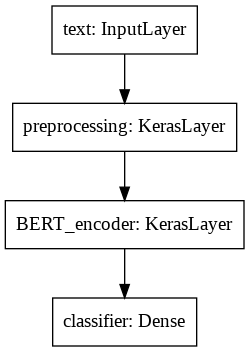

In [28]:
tf.keras.utils.plot_model(classifier_model)

In [29]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False,label_smoothing=0,name='categorical_crossentropy')
metrics = tf.metrics.CategoricalAccuracy()

In [35]:
epochs = 40
steps_per_epoch = x_train.shape[0]/10
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [36]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [37]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x_train,y_train,epochs=epochs,validation_split=0.2)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Epoch 1/40
54/54 [==============================] - 36s 625ms/step - loss: 1.7129 - categorical_accuracy: 0.5523 - val_loss: 1.8255 - val_categorical_accuracy: 0.5222
Epoch 2/40
54/54 [==============================] - 32s 598ms/step - loss: 1.7060 - categorical_accuracy: 0.5633 - val_loss: 1.8189 - val_categorical_accuracy: 0.5246
Epoch 3/40
54/54 [==============================] - 33s 603ms/step - loss: 1.6873 - categorical_accuracy: 0.5668 - val_loss: 1.8098 - val_categorical_accuracy: 0.5246
Epoch 4/40
54/54 [==============================] - 32s 600ms/step - loss: 1.6796 - categorical_accuracy: 0.5651 - val_loss: 1.7995 - val_categorical_accuracy: 0.5269
Epoch 5/40
54/54 [==============================] - 33s 616ms/step - loss: 1.6790 - categorical_accuracy: 0.5651 - val_loss: 1.7888 - val_categorical_accuracy: 0.5293
Epoch 6/40
54/54 [==============================] - 34s 635ms/step - loss

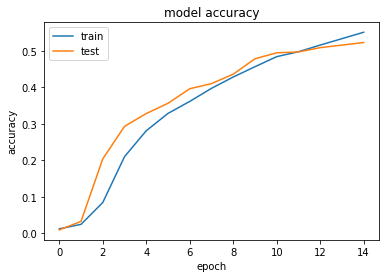

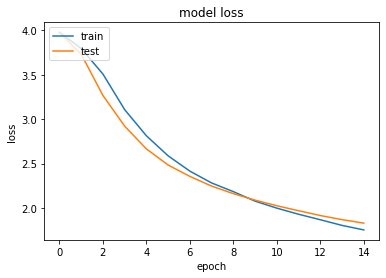

In [34]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Epochs 1-15

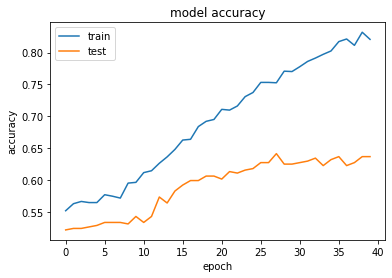

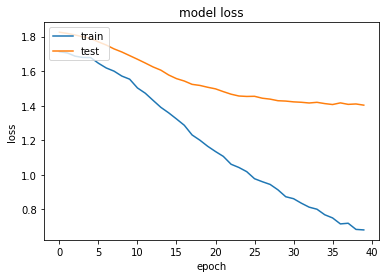

In [38]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Epochs 16-55

In [39]:
classifier_model.save("BERT_model")

In [51]:
x_test = np.array(['Mac Book'])
ans = classifier_model.predict(x_test)
max_index = np.argmax(ans)
print(idx2cat[max_index])

Computers & Tablets


In [52]:
x_test = np.array(['Guitar'])
ans = classifier_model.predict(x_test)
max_index = np.argmax(ans)
print(idx2cat[max_index])

Musical Instruments
